# Object Detection 

# Imports

In [4]:
import sys
sys.path.append("../app")

In [18]:
import numpy as np
import os
import six.moves.urllib as urllib
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# imports for drawing graphics
import gizeh as gz
import jsonlines as json
import struct
from struct import unpack
from pathlib import Path
import random
import jsonlines
import png

## Env setup

In [10]:
# This is needed to display the images.
%matplotlib inline
random.seed()

## Object detection

In [11]:
class ImageProcessor():
    
    def __init__(self):
        self._model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
        # Path to frozen detection graph. This is the actual model that is used for the object detection.
        self._path_to_CKPT = os.path.join('..', 'downloads', 'detection_models', self._model_name, 'frozen_inference_graph.pb')
        # List of the strings that is used to add correct label for each box.
        self._path_to_labels = os.path.join('..', 'app', 'object_detection', 'data', 'mscoco_label_map.pbtxt')
        self._num_classes = 90
        self._detection_graph = None
        self._labels = dict()
        
    def setup(self):
        MODEL_FILE = self._model_name + '.tar.gz'
        #DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
        #self.download_model(DOWNLOAD_BASE, MODEL_FILE)
        self.load_model(self._path_to_CKPT)
        self._labels = self.load_labels(self._path_to_labels)
        
    def download_model(self, url, filename):
        """download a model file from the url and unzip it
        """
        opener = urllib.request.URLopener()
        opener.retrieve(url + filename, filename)
        tar_file = tarfile.open(filename)
        for file in tar_file.getmembers():
            file_name = os.path.basename(file.name)
            if 'frozen_inference_graph.pb' in file_name:
                tar_file.extract(file, os.getcwd())
            
    def load_model(self, path):
        """load saved model from protobuf file
        """
        self._detection_graph = tf.Graph()
        with self._detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(path, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')
                
    def load_labels(self, path):
        """load labels from .pb file, and map to a dict with integers, e.g. 1=aeroplane
        """
        label_map = label_map_util.load_labelmap(path)
        categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=self._num_classes, use_display_name=True)
        category_index = label_map_util.create_category_index(categories)
        return category_index
    
    def load_image_into_numpy_array(self, path):
        """load image into NxNx3 numpy array
        """
        image = Image.open(path)
        (im_width, im_height) = image.size
        return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
    
    def detect(self, image):
        """detect objects in the image
        """
        with self._detection_graph.as_default():
            with tf.Session(graph=self._detection_graph) as sess:
                # Definite input and output Tensors for detection_graph
                image_tensor = self._detection_graph.get_tensor_by_name('image_tensor:0')
                # Each box represents a part of the image where a particular object was detected.
                detection_boxes = self._detection_graph.get_tensor_by_name('detection_boxes:0')
                # Each score represent how level of confidence for each of the objects.
                # Score is shown on the result image, together with the class label.
                detection_scores = self._detection_graph.get_tensor_by_name('detection_scores:0')
                detection_classes = self._detection_graph.get_tensor_by_name('detection_classes:0')
                num_detections = self._detection_graph.get_tensor_by_name('num_detections:0')
                # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                image_np_expanded = np.expand_dims(image, axis=0)
                # Actual detection.
                (boxes, scores, classes, num) = sess.run(
                  [detection_boxes, detection_scores, detection_classes, num_detections],
                  feed_dict={image_tensor: image_np_expanded})
                return boxes, scores, classes, num
            
    @property
    def labels(self):
        return self._labels

## Drawing Dataset

interface to the google draw dataset

In [12]:
class DrawingDataset():
    
    def __init__(self, path_to_drawing_dataset):
        self._path = Path(path_to_drawing_dataset)
        self._categories_filepath = self._path / 'categories.txt'
        self._categories = []
        self._category_mapping = dict()
        
    def setup(self, path_to_label_mapping):
        self._categories = self.load_categories(self._path)
        if self._categories is []:
            print('no drawings available, please download quickdraw dataset')
        try:
            with jsonlines.open(path_to_label_mapping, mode='r') as reader:
                self._category_mapping = reader.read()
        except FileNotFoundError as e:
            print('label_mapping.jsonl not found')
        
    def download(self, url, filename, path):
        """download file @ specified url and save it to path
        """
        if not Path(path).exists():
            Path(path).mkdir()
        fpath = Path(path) / filename
        opener = urllib.request.URLopener()
        opener.retrieve(url, str(fpath))
        return fpath
    
    def download_recurse(self, url, path):
        """download all available files from url
        """
        path = Path(path)
        with open(self._categories_filepath) as f:
            categories = f.readlines()
        categories = [cat.strip() for cat in categories]
        for cat in categories:
            site = url + cat.replace(' ', '%20') + '.bin'
            fpath = self.download(site, cat + '.bin', path)
            print('downloaded: {} from {}'.format(fpath, site))
            
    def load_categories(self, path):
        files = Path(path).glob('*.bin')
        categories = [f.stem for f in files]
        return categories
        
    def _unpack_drawing(self, file_handle):
        """unpack single drawing from google draw dataset binary files
        """
        key_id, = unpack('Q', file_handle.read(8))
        countrycode, = unpack('2s', file_handle.read(2))
        recognized, = unpack('b', file_handle.read(1))
        timestamp, = unpack('I', file_handle.read(4))
        n_strokes, = unpack('H', file_handle.read(2))
        image = []
        for i in range(n_strokes):
            n_points, = unpack('H', file_handle.read(2))
            fmt = str(n_points) + 'B'
            x = unpack(fmt, file_handle.read(n_points))
            y = unpack(fmt, file_handle.read(n_points))
            image.append((x, y))

        return {
            'key_id': key_id,
            'countrycode': countrycode,
            'recognized': recognized,
            'timestamp': timestamp,
            'image': image 
        }

    def unpack_drawings(self, path):
        """read all drawings from binary file, and return a generator
        """
        with open(path, 'rb') as f:
            while True:
                try:
                    yield self._unpack_drawing(f)
                except struct.error:
                    break
                    
    def get_drawing(self, name, index):
        """get a drawing by name and index, e.g. 100th 'pelican'
        """
        try:
            if name not in self._categories:
                # try and get the closest matching drawing. If nothing suitable foumd then return a scorpion
                name = self._category_mapping.get(name, 'scorpion')
            if index < 1 or not isinstance(index, int):
                raise ValueError('index must be integer > 0')
            itr = self.unpack_drawings(str(self._path / Path(name).with_suffix('.bin')))
            for i in range(index):
                drawing = next(itr)
            return drawing['image']
        except ValueError as e:
            print(repr(e))
            
    
    @property
    def categories(self):
        return self._categories

## Sketcher

sketches drawing

In [13]:
class Sketch():
    
    def __init__(self):
        self._surface = None
        
    def setup(self, width=1200, height=900, bg_color=(1,1,1)):
        self._width = width
        self._height = height
        self._surface = gz.Surface(width=width, height=height, bg_color=bg_color)
    
    def draw(self, strokes, scale=0.1, pos=[0,0], stroke_width=5, color=[0,0,0]):
        """iterate through a list of strokes, drawing them on the canvas
        pos is normalised coprdinates in range (0,1)
        """
        try:
            for val in pos:
                if val < 0 or val > 1 or not isinstance(val, float):
                    raise ValueError('position coordinates should be float between (0,1)')
            print(pos, scale)
            scale *= np.mean([self._width, self._height]) / 255
            pos[0] =  pos[0] * self._width - (scale * (255/2))
            pos[1] =  pos[1] * self._height - (scale * (255/2))
            lines = self._convert_quickdraw_strokes_to_gizeh_group(strokes, color, stroke_width=stroke_width/scale)
            lines = lines.scale(scale).translate(xy=pos)
            lines.draw(self._surface)
        except ValueError as e:
            print(repr(e))
            
    def draw_person(self, dataset, scale=1.0, position=[0, 0]):
        body_parts = {'face': [0,0], 't-shirt': [0, 250], 'pants': [0, 480]} #dict of parts + translation
        gz_body_parts = []
        for  name, pos in body_parts.items():
            strokes = dataset.get_drawing(name, random.randint(1, 1000))
            strokes_gz = self._convert_quickdraw_strokes_to_gizeh_group(strokes, stroke_width=3/scale)
            strokes_gz = strokes_gz.translate(pos)
            gz_body_parts.append(strokes_gz)
        scale *= np.mean([self._width, self._height]) / 750
        pos[0] =  position[0] * self._width - (scale * (255/2))
        pos[1] =  position[1] * self._height - (scale * (750/2))
        gz_body_parts = gz.Group(gz_body_parts).scale(scale).translate(xy=pos)
        gz_body_parts.draw(self._surface)
            
    def _convert_quickdraw_strokes_to_gizeh_group(self, strokes, color=[0,0,0], stroke_width=5):
        lines_list = []
        for stroke in strokes:
            x, y = stroke
            points = list(zip(x, y))
            line = gz.polyline(points=points, stroke=color, stroke_width=stroke_width)
            lines_list.append(line)
        return gz.Group(lines_list)
        
    def draw_object_recognition_results(self, boxes, classes, scores, labels, dataset, min_score_thresh=0.5):
        """draw results of object recognition
        """
        for i in range(boxes.shape[0]):
            if scores is None or scores[i] > min_score_thresh:
                box = tuple(boxes[i].tolist())
                if classes[i] in labels.keys():
                    class_name = labels[classes[i]]['name']
                else:
                    raise ValueError('no label for index {}'.format(i))
                ymin, xmin, ymax, xmax = box
                centre = [np.mean([xmin, xmax]), np.mean([ymin, ymax])]
                size = np.mean([xmax - xmin, ymax - ymin])
                if class_name == 'person':
                    self.draw_person(dataset, scale=ymax-ymin, position=centre)
                else:
                    drawing = dataset.get_drawing(class_name, random.randint(1, 1000))
                    self.draw(drawing, scale=size, pos=centre)
                
    def get_npimage(self):
        return self._surface.get_npimage()
    
    def save_png(self, path):
        self._surface.write_to_png(path)

## Mapping object labels to drawing categories

In [38]:
import nltk
import operator
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

In [41]:
object_names = [val['name'] for key, val in detect.labels.items()]

In [54]:
mapping = dict()
for ob in object_names:
    ob_wn = wn.synsets(ob)
    if len(ob_wn) > 0:
        ranking = dict()
        for category in dataset.categories:
            cat_wn = wn.synsets(category)
            if len(cat_wn) > 0:
                ranking[category] = ob_wn[0].wup_similarity(cat_wn[0])
            else:
                pass
                #print('no wordnet entry found for drawing category: {}'.format(category))
        match = max(ranking, key=ranking.get)
        mapping[ob] = match
        #print(ranking)
    else:
        print('no wordnet entry found for image label: {}'.format(ob))

no wordnet entry found for image label: traffic light
no wordnet entry found for image label: fire hydrant
no wordnet entry found for image label: stop sign
no wordnet entry found for image label: parking meter
no wordnet entry found for image label: sports ball
no wordnet entry found for image label: baseball bat
no wordnet entry found for image label: baseball glove
no wordnet entry found for image label: tennis racket
no wordnet entry found for image label: wine glass
no wordnet entry found for image label: hot dog
no wordnet entry found for image label: potted plant
no wordnet entry found for image label: dining table
no wordnet entry found for image label: cell phone
no wordnet entry found for image label: teddy bear
no wordnet entry found for image label: hair drier


In [56]:
import jsonlines

In [57]:
with jsonlines.open('label_mapping_new.jsonl', mode='w') as writer:
    writer.write(mapping)

# Model preparation 

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [14]:
detect = ImageProcessor()
detect.setup()

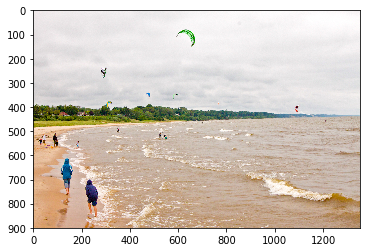

In [31]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '../app/object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


img = detect.load_image_into_numpy_array(TEST_IMAGE_PATHS[1])
plt.imshow(img)

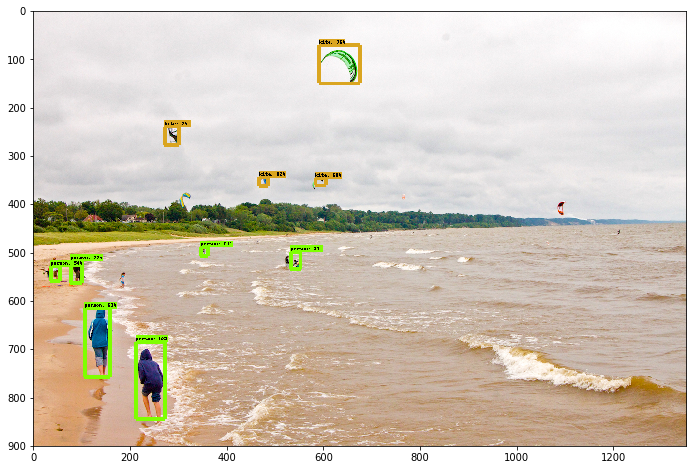

In [33]:
(boxes, scores, classes, num) = detect.detect(img)
# Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
  img,
  np.squeeze(boxes),
  np.squeeze(classes).astype(np.int32),
  np.squeeze(scores),
  detect.labels,
  use_normalized_coordinates=True,
  line_thickness=8)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(img)

## Scratchpad

[0.35242700576782227, 0.39257368445396423] 0.0162301361561
[0.46900597214698792, 0.12290843576192856] 0.0745908841491
[0.21210840344429016, 0.28658896684646606] 0.0319316089153
[0.43972635269165039, 0.39291635155677795] 0.0158202946186


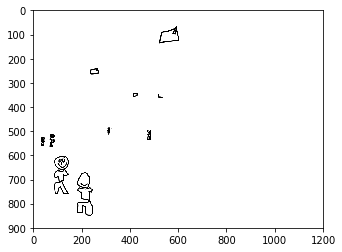

In [20]:
dataset = DrawingDataset('../downloads/drawing_dataset')
dataset.setup('../app/label_mapping.jsonl')
#dataset.download_recurse('https://storage.googleapis.com/quickdraw_dataset/full/binary/', './drawings')
sk = Sketch()
sk.setup()
sk.draw_object_recognition_results(np.squeeze(boxes),
                                   np.squeeze(classes).astype(np.int32),
                                   np.squeeze(scores),
                                   detect.labels,
                                   dataset)
plt.imshow(sk.get_npimage())

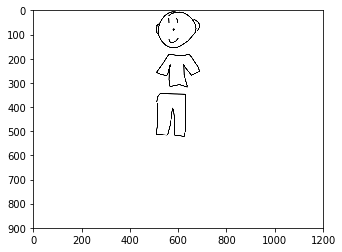

In [24]:
sk = Sketch()
sk.setup()
sk.draw_person(dataset, scale=0.5, position=[0.5, 0.3])
plt.imshow(sk.get_npimage())

In [34]:
img = img
with open('annotated.png', 'wb') as f:
    writer = png.Writer(img.shape[1], img.shape[0], greyscale=False, bitdepth=8)
    writer.write(f, np.reshape(img, (-1, img.shape[1]*img.shape[2])))

In [22]:
img = sk.get_npimage()
img.dtype

dtype('uint8')